# Import del Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#%% IMPORT WEATHER DATASET
#Caricamento del dataset contenente i dati metereologici
weather_data = pd.read_csv("../data/raw/weather_prediction_dataset.csv")

#print(weather_data.head())

print(f"Il weather dataset ha {weather_data.shape[0]} record e {weather_data.shape[1]} colonne")


print("Etichette colonne weather_data:")
print(weather_data.columns)
# for etichetta_colonna in weather_data.columns:
#     print(etichetta_colonna)
print()

#%% IMPORT BBQ LABEL DATASET
#Caricamento del dataset indicante le registrazioni con meteo da bbq e quelle non
classification_data = pd.read_csv("../data/raw/weather_prediction_bbq_labels.csv")

#print(classification_data.head())
print(f"Il bbq label dataset ha {classification_data.shape[0]} record e {classification_data.shape[1]} colonne")

print("Etichette colonne classification_data:")
print(classification_data.columns)
# for etichetta_colonna in classification_data.columns:
#     print(etichetta_colonna)
print()


Il weather dataset ha 3654 record e 165 colonne
Etichette colonne weather_data:
Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max', 'TOURS_wind_speed',
       'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
       'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min',
       'TOURS_temp_max'],
      dtype='object', length=165)

Il bbq label dataset ha 3654 record e 18 colonne
Etichette colonne classification_data:
Index(['DATE', 'BASEL_BBQ_weather', 'BUDAPEST_BBQ_weather', 'DE_BBQ_weather',
       'DRESDEN_BBQ_weather', 'DUSSELDORF_BBQ_weather', 'HEATHROW_BBQ_weather',
       'KASSEL_BBQ_weather', 'LJUBLJANA_BBQ_weather', 'MAASTRICHT_BBQ_weather',
       'MALMO_BBQ_weather', 'MONTELIMAR_BBQ_weather', 'MUENCHEN_BBQ_weather',
       'OSLO_BBQ_weather', 'PERPIGNAN_

Sono presenti due dataset, *weather_data* contenente 3654 registrazioni metereologiche giornaliere per 18 città, e *classificazion_data* che per ogni registrazione in ogni città classifica la giornata come adatta (true) e non adatta (false) al barbeque.

## Costruzione Sottodatabase

In [2]:
#%% INDIVIDUAZIONE SOTTODATABASE 
#lista_città = [s.replace("_BBQ_weather", "") for s in classification_data.columns[1:]]
conteggi = {}

for item in weather_data.columns[2:]:
    citta = item.split("_")[0]
    if citta in conteggi:
        conteggi[citta] += 1
    else:
        conteggi[citta] = 1

numero_parametri = max(conteggi.values())
print("Numero parametri meteorologici per città:")
for citta, conteggio in conteggi.items():
    print(f"{citta}: {conteggio}")    
print()
#Roma non è presente nel classification_data
print(f"Numero città weather dataset: {len(conteggi.keys())}")
print(f"Numero città bbq label dataset: {len(classification_data.columns) -1}")

Numero parametri meteorologici per città:
BASEL: 9
BUDAPEST: 8
DE: 11
DRESDEN: 10
DUSSELDORF: 11
HEATHROW: 9
KASSEL: 10
LJUBLJANA: 10
MAASTRICHT: 11
MALMO: 5
MONTELIMAR: 8
MUENCHEN: 11
OSLO: 11
PERPIGNAN: 8
ROMA: 8
SONNBLICK: 8
STOCKHOLM: 7
TOURS: 8

Numero città weather dataset: 18
Numero città bbq label dataset: 17


Tramite un dizionario vengono contanti il numero di parametri metereologici registrati per ogni città. Si noti che il numero massimo di parametri registrati è 11. Si noti inoltre che il numero di città presenti nel secondo dataset sono una in meno. Da una rapida lettura dei campi del db è possibile osservare che **manca ROMA**.

## Selezione città: OSLO

In [3]:
#Selezione città e individuazione indici
citta = "OSLO"
chiavi = list(conteggi.keys())
valori = list(conteggi.values())
indici_citta = [0,0]
indici_citta[0] = sum(valori[:chiavi.index(citta)]) + 2
indici_citta[1] = indici_citta[0] + conteggi[citta]

#print(indici_citta)

#Costruzione dataset città
df = weather_data.iloc[:, indici_citta[0] : indici_citta[1]]
df["MONTH"] = weather_data.iloc[:, 1]
df["BBQ"] = classification_data[citta + "_BBQ_weather"][:]
df["DATE"] = classification_data["DATE"]
df.to_csv(f"../data/processed/{citta}_weather_dataset.csv")

Le città con 11 parametri metereologici sono DUSSELDORF, MAASTRICHT, MUENCHEN, OSLO. Poichè la classificazione finale si basa sui dati metereologici, e poichè essi sono influenzati dalla posizione geografica della città, si sceglie di operare su una sola città. 
In particolare viene scelta OSLO. 
Vengono individuate le colonne del *weather_data* db relative ad OSLO, vengono estratte e unite con la colonna di classificazione della città di OSLO contenuta nel *classification_data* db, ottenendo così il database su cui lavorare.

# Pre-processing

## Rimozione NaN e duplicati

In [4]:
#Analisi valori nulli
print("Valori NaN")
print(df.isnull().sum())

#Rimozione valori nulli
df.dropna(inplace = True)

Valori NaN
OSLO_cloud_cover         0
OSLO_wind_speed          0
OSLO_wind_gust           0
OSLO_humidity            0
OSLO_pressure            0
OSLO_global_radiation    0
OSLO_precipitation       0
OSLO_sunshine            0
OSLO_temp_mean           0
OSLO_temp_min            0
OSLO_temp_max            0
MONTH                    0
BBQ                      0
DATE                     0
dtype: int64


## Variabili categoriche e numeriche

In [5]:
#Impostiamo variabili categoriche quelle che non sono numeriche
num_type = ["float64", "int64"]

for col in df.columns:
    print(f"{col} type: {df[col].dtype}.")
    if df[col].dtype not in num_type:
        df[col] = df[col].astype("category")
        print(f"{col} type: {df[col].dtype}.")
    print("-" * 45)

df["MONTH"]=df["MONTH"].astype("category")
df["BBQ"]=df["BBQ"].astype("category")
df["DATE"] = df["DATE"].astype("category")

#Sub-dataset con solo colonne numeriche
colonne_numeriche = df.select_dtypes(include=num_type)

#Rimuoviamo la colonna con le date
df.drop(columns = ["DATE"], inplace=True)

OSLO_cloud_cover type: int64.
---------------------------------------------
OSLO_wind_speed type: float64.
---------------------------------------------
OSLO_wind_gust type: float64.
---------------------------------------------
OSLO_humidity type: float64.
---------------------------------------------
OSLO_pressure type: float64.
---------------------------------------------
OSLO_global_radiation type: float64.
---------------------------------------------
OSLO_precipitation type: float64.
---------------------------------------------
OSLO_sunshine type: float64.
---------------------------------------------
OSLO_temp_mean type: float64.
---------------------------------------------
OSLO_temp_min type: float64.
---------------------------------------------
OSLO_temp_max type: float64.
---------------------------------------------
MONTH type: int64.
---------------------------------------------
BBQ type: bool.
BBQ type: category.
---------------------------------------------
DATE type:

## Outliers

### Boxplot

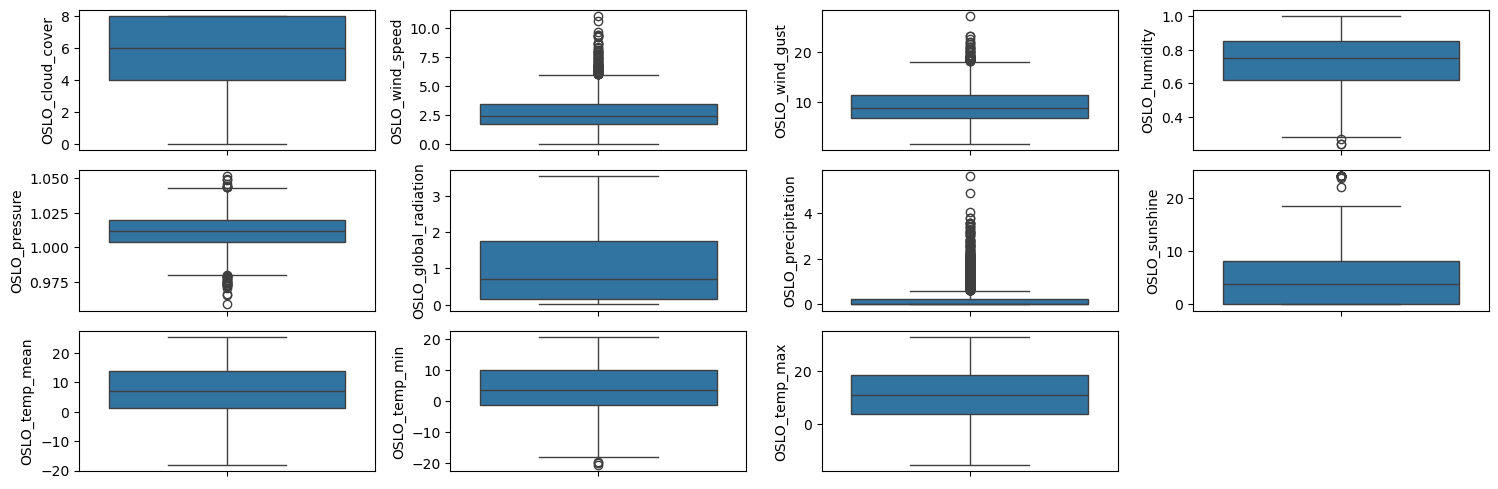

In [6]:
#BoxPlot delle colonne numeriche per individuazione outliers
#Viene scelta una distribuzione su 3 righe e 4 colonne perchè il numero massimo di features metereologiche è 11
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 5))

for i, colonna in enumerate(colonne_numeriche):
    ax = axes[i // 4, i % 4]
    sns.boxplot(data = df[colonna], ax = ax)
    plt.title(f"{colonna}")

# Nascondi gli assi non utilizzati
for j in range(i + 1, 3 * 4):
    fig.delaxes(axes[j // 4, j % 4])
    
plt.tight_layout()
plt.show()

I boxplot mostrano i 5 numeri di sintesi per ogni feature, indicando i potenziali outliers (distanza dal centro superiore a 1,5 volte l'ampiezza IQR). Va considerato che le condizioni metereologiche a volte, seppur non frequentemente, possono risultare estreme. Questo è valido soprattutto per la temperatura, per le precipitazioni e per il vento. 

### Valutazione outliers

In [12]:
riassunto = colonne_numeriche.describe()
estremi = riassunto.loc[["min", "max"]]
print(estremi)

     OSLO_cloud_cover  OSLO_wind_speed  OSLO_wind_gust  OSLO_humidity  \
min               0.0              0.0             1.5           0.24   
max               8.0             11.0            27.3           1.00   

     OSLO_pressure  OSLO_global_radiation  OSLO_precipitation  OSLO_sunshine  \
min         0.9590                   0.01                 0.0            0.0   
max         1.0511                   3.53                 5.6           24.0   

     OSLO_temp_mean  OSLO_temp_min  OSLO_temp_max  
min           -18.1          -20.7          -15.6  
max            25.4           20.7           33.0  


I valori estremi delle temperature sembrano essere ragionevoli. Considerando i dati storici, la minor temperatura mai registrata ad Oslo corrisponde a -26.3 C, mentre la maggiore 35.6C

La nuvolosità del cielo è misurata in oktas, un indice che assume valori in [0, 8], con 0 cielo limpido e 8 cielo completamente coperto.

In [8]:
#OSLO è sotto al circolo polare artico, 
#le ore di luce dunque non possono essere più di 20
df = df[df[f"{citta}_sunshine"] < 20]

Considerando che il Oslo risiede sotto il circolo polare artico, e anche sotto il 60esimo grado di latitudine a cui si può verificare il fenomeno del *sole di mezzanotte*, considerando errati, e quindi da eliminare, i record con più di 20 ore di luce.

### Rimozione outliers sospetti

In [16]:
def calcola_outliers(valori):
    # Converti l'array in un array NumPy
    valori = np.array(valori)

    # Calcola il primo quartile (Q1), il terzo quartile (Q3) e IQR
    Q1 = np.percentile(valori, 25)
    Q3 = np.percentile(valori, 75)
    IQR = Q3 - Q1
    
    # Calcola i limiti per gli outliers
    limite_inferiore = Q1 - 3 * IQR
    limite_superiore = Q3 + 3 * IQR
    
    return limite_inferiore, limite_superiore

for colonna in ["_wind_speed", "_wind_gust", "_humidity", "_pressure", "_precipitation"]:
    colonna = f"{citta}" + colonna
    limite_inferiore, limite_superiore = calcola_outliers(df[colonna])
    df = df[(df[colonna] > limite_inferiore) & (df[colonna] < limite_superiore)]

Escludiamo gli outliers sospetti (distanza dal centro superiore a 3 volte l'ampiezza IQR) delle colonne relative a velocità del vento, velocità delle raffiche di vento, umidità, pressione e precipitazioni. Adottiamo un approccio conservativo in virtù della possibilità di registrare fenomeni metereologici estremi con una certa frequenza specialmente per effetto del *global warming*.

# EDA

## Distribuzione valori

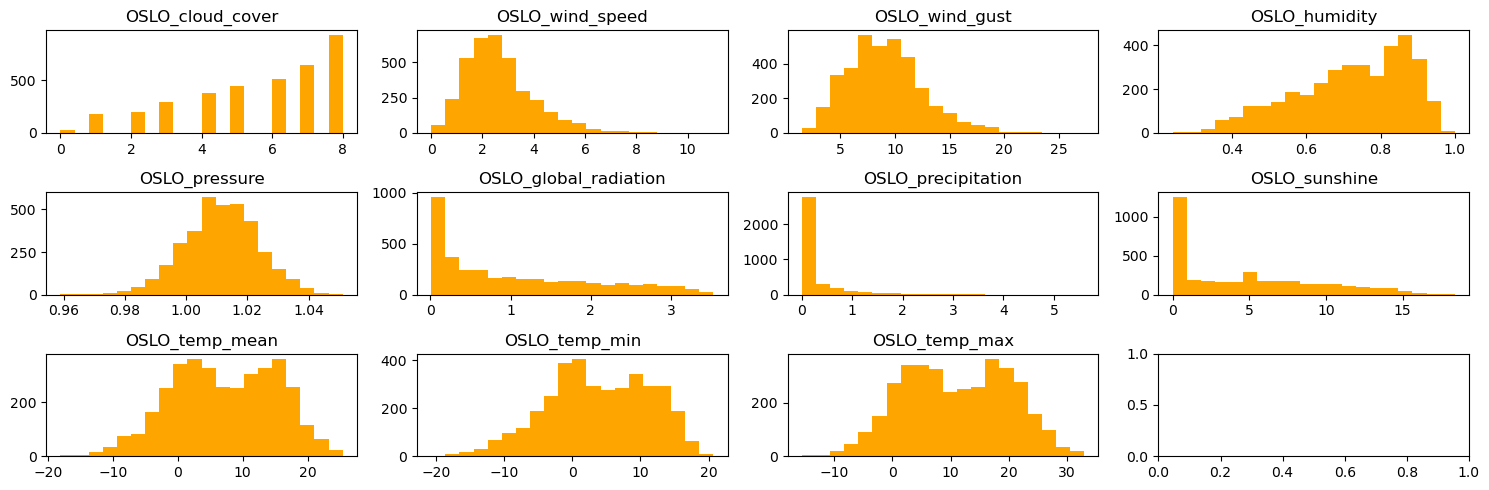

In [9]:
#Distribuzione valori colonne numeriche
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 5))


for i, colonna in enumerate(colonne_numeriche):
    ax = axes[i // 4, i % 4]
    ax.hist(df[colonna], bins = 20, color="orange")
    ax.set_title(f"{colonna}")

plt.tight_layout()
plt.show()